In [1]:
%%html
<img src="logo.jpg",width=60,height=60>

Lapage était originellement une librairie physique avec plusieurs points de vente. Mais devant le succès de certains de ses produits et l’engouement de ses clients, elle a décidé depuis 2 ans d’ouvrir un site de vente en ligne.   
Vous intervenez car l’entreprise souhaite faire le point après deux ans d’exercice, et pouvoir analyser ses points forts, ses points faibles, les comportements clients, etc.

[1 - Analyse des clients](#1---Etude-des-clients)  
[2 - Analyse du chiffre d'affaires global](#2---Analyse-du-CA-global)  
[3 - Corrélations et dépendances](#3---Corrélations-et-dépendances)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from my_module import*
from dataprep.eda import create_report

from scipy.stats import pearsonr
from scipy.stats import shapiro

import statsmodels.formula.api
import statsmodels.api
import scipy.stats as stats
from scipy.stats import chi2_contingency as chi2_contingency


sns.set(style="darkgrid", palette="rainbow")
pd.set_option("display.float_format", lambda x: "%.2f" % x)

import warnings
warnings.filterwarnings('ignore')

NumExpr defaulting to 4 threads.


In [3]:
df = pd.read_pickle("data/df_prod.pkl")
df_customer = pd.read_pickle("data/df_customer.pkl")

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679331
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id_prod         679332 non-null  object        
 1   date            679332 non-null  datetime64[ns]
 2   session_id      679332 non-null  object        
 3   client_id       679332 non-null  object        
 4   time            679332 non-null  object        
 5   price           679332 non-null  float64       
 6   categ           679332 non-null  category      
 7   sex             679332 non-null  object        
 8   age             679332 non-null  int64         
 9   purchase_month  679332 non-null  int64         
 10  client_type     679332 non-null  object        
dtypes: category(1), datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 57.7+ MB


In [5]:
df.head()

id_prod       date session_id client_id             time  price categ sex  \
0  0_1518 2022-05-20   s_211425     c_103  13:21:29.043970   4.18     0   f   
1  0_1518 2021-07-20    s_64849     c_103  13:21:29.043970   4.18     0   f   
2  0_1518 2022-08-20   s_255965     c_103  13:21:29.043970   4.18     0   f   
3  0_1418 2022-06-18   s_225411     c_103  01:49:37.823274   8.57     0   f   
4  0_1418 2021-08-18    s_77214     c_103  01:49:37.823274   8.57     0   f   

   age  purchase_month  
0   37               5  
1   37               7  
2   37               8  
3   37               6  
4   37               8

In [6]:
search_cardinality(df)

id_prod
Cardinality - The variable id_prod has 3266 distinct values.
--------------------------------------------------------------------------------
date
Cardinality - The variable date has 730 distinct values.
--------------------------------------------------------------------------------
session_id
Cardinality - The variable session_id has 342315 distinct values.
--------------------------------------------------------------------------------
client_id
Cardinality - The variable client_id has 8600 distinct values.
--------------------------------------------------------------------------------
time
Cardinality - The variable time has 337816 distinct values.
--------------------------------------------------------------------------------
price
Cardinality - The variable price has 1442 distinct values.
--------------------------------------------------------------------------------
categ
[0, 1, 2]
Categories (3, int64): [0, 1, 2]
------------------------------------------------------

**3266 produits différents  
342315 transactions sur 730 jours (2 ans exactement, du 1er avril 2021 au 30 mars 2023) 
8600 clients différents  
3 catégories**

---
---

# 1 - Etude des clients

### 1-1 Analyse de l'âge et du genre

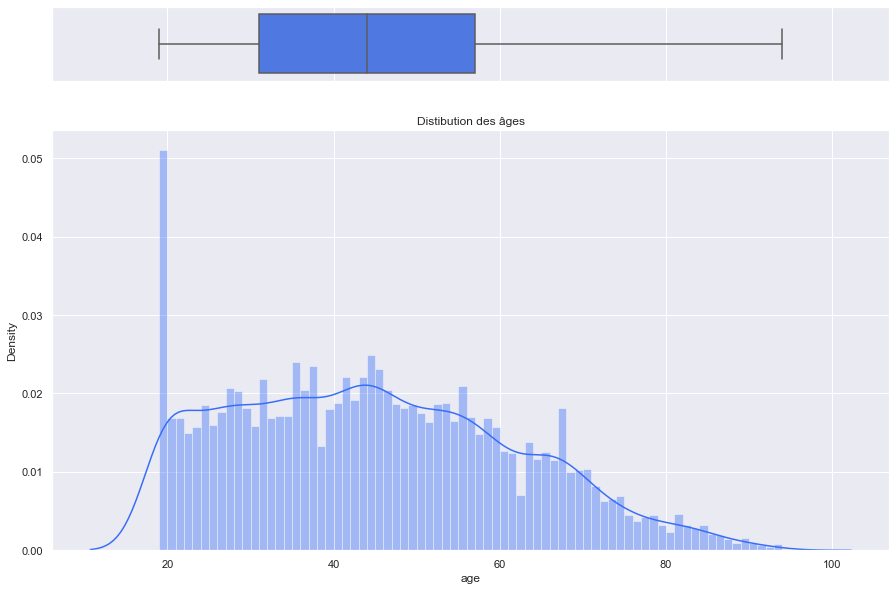

In [7]:
# Analyse de la distribution des âges
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
f.set_figheight(10)
f.set_figwidth(15)
plt.title("Distibution des âges")
sns.boxplot(df_customer["age"], ax=ax_box)
sns.distplot(a=df_customer["age"], hist=True, kde=True, bins=75, ax=ax_hist)
ax_box.set(xlabel='')
plt.show();

In [8]:
df_customer[df_customer["age"] == 19].nunique()

client_id    440
sex            2
birth          1
age            1
dtype: int64

**440 clients nés en 2004.  
Valeur plutôt disproportionnée qui peut s'expliquer par plusieurs hypothèses :**
- Vente de produits qui intéresse particulièrement cet âge
- Fausse déclaration pour correspondre à l'âge minimum pour effectuer un achat

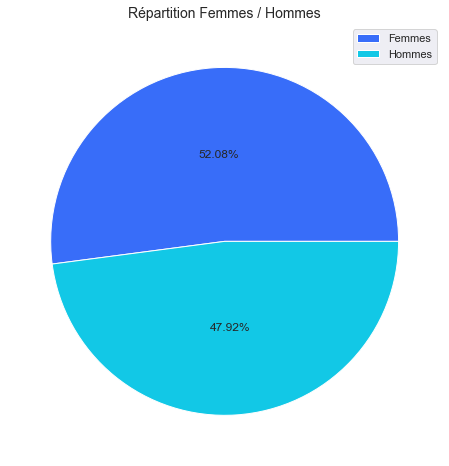

In [9]:
# Proportion h/f
df_customer_sex = df_customer.groupby("sex").count().reset_index()
values = df_customer_sex["client_id"]
labels = ["Femmes", "Hommes"]
plt.figure(figsize=(8, 8))
plt.pie(values, autopct='%.2f%%', pctdistance=0.5)
plt.title("Répartition Femmes / Hommes", fontsize=14)
plt.legend(labels)
plt.show();

Notre clientèle est identiquement distribuée que celle de la France.  
Source : <a href="https://www.insee.fr/fr/statistiques/4238375?sommaire=4238781#:~:text=Au%201er%20janvier%202019,24%20ans%20(figure%201).">INSEE</a>

In [10]:
# Discrétisation de la variable age en 4 intervalles (jeunes adultes, adultes, sénior)
df_customer["int_age"] = pd.cut(df_customer["age"], bins=[0, 30, 50, 70, 100])

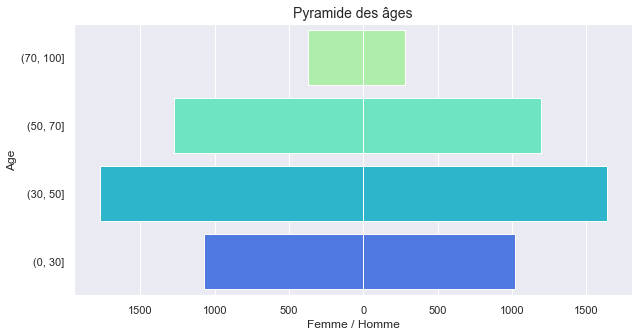

In [11]:
# Pyramide des âges de la clientèle
df_pyramid = df_customer.pivot_table(index="int_age", columns="sex", values="client_id", aggfunc="count").reset_index()
y_age = df_pyramid['int_age']
x_M = df_pyramid['m']
x_F = df_pyramid['f'] * -1

plt.figure(figsize=(10, 5))
ax1 = sns.barplot(x=x_M, y=y_age)
ax2 = sns.barplot(x=x_F, y=y_age)
plt.ylim(reversed(plt.ylim()))
plt.title("Pyramide des âges", fontsize=14)
plt.ylabel("Age")
plt.xlabel("Femme / Homme")
plt.xticks(ticks=[-1500, -1000, -500, 0, 500, 1000, 1500], labels=[1500, 1000, 500, 0, 500, 1000, 1500])
plt.show();

Déséquilibre dans la répartion des séniors+ : la proportion de femmes est plus importante.

---

### 1-2 Analyse du CA des clients

In [12]:
# CA par client
df_ca_client = df.groupby("client_id").price.sum().reset_index()
df_ca_client.sort_values("price", ascending=False).head(10)

client_id     price
677     c_1609 324033.35
4388    c_4958 289760.34
6337    c_6714 153658.86
2724    c_3454 113667.90
2513    c_3263   5276.87
634     c_1570   5271.62
2108    c_2899   5214.05
1268    c_2140   5208.82
7006    c_7319   5155.77
7791    c_8026   5092.57

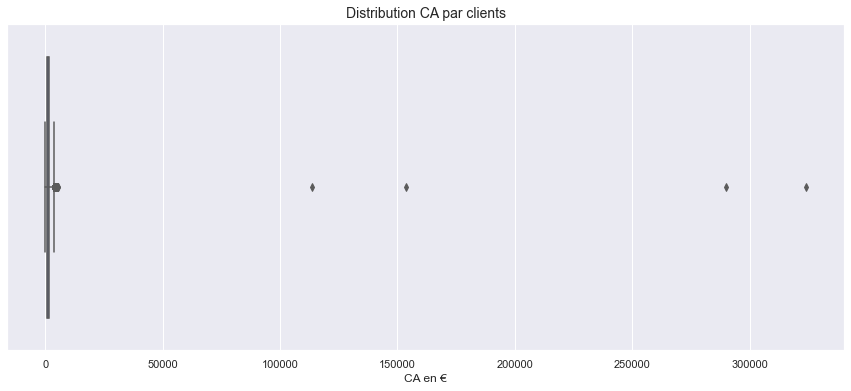

In [13]:
# Boxplot avec outliers
plt.figure(figsize=(15,6))
sns.boxplot(x="price", data=df_ca_client)
plt.xlabel("CA en €")
plt.title("Distribution CA par clients", fontsize=14)
plt.show();

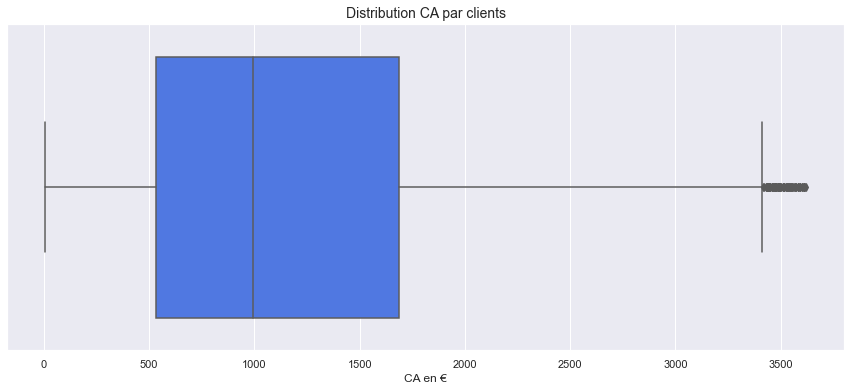

In [14]:
# Boxplot sans outliers
plt.figure(figsize=(15,6))
sns.boxplot(x="price", data=drop_outliers(df_ca_client, "price"))
plt.xlabel("CA en €")
plt.title("Distribution CA par clients", fontsize=14)
plt.show();

In [15]:
# Nb de ventes par client
df.groupby("client_id").price.count().reset_index().sort_values("price", ascending=False)

client_id  price
677     c_1609  25488
6337    c_6714   9187
2724    c_3454   6773
4388    c_4958   5195
2513    c_3263    403
...        ...    ...
1556     c_240      1
5501    c_5962      1
8151    c_8351      1
3855    c_4478      1
5868    c_6292      1

[8600 rows x 2 columns]

Présence de 4 outliers très marqués, probablement des clients pro ayant effectué entre 5000 et 25500 achats pour un montant total de 113000 à 324000 € sur la période.  
Création de 2 dataframes, df_b2b et df_b2c pour les distinguer et ajout d'un tag B2B ou B2C dans df.

In [16]:
# Création de la liste des clients B2B
list_b2b = list(df_ca_client[df_ca_client["price"] > 100000]["client_id"])

# Création de la variable client_type
df["client_type"] = np.where(df["client_id"].isin(list_b2b), "B2B", "B2C")

# Création des dataframes B2B et B2C
df_b2b = df[df["client_id"].isin(list_b2b)]
df_b2c = df[~df["client_id"].isin(list_b2b)]

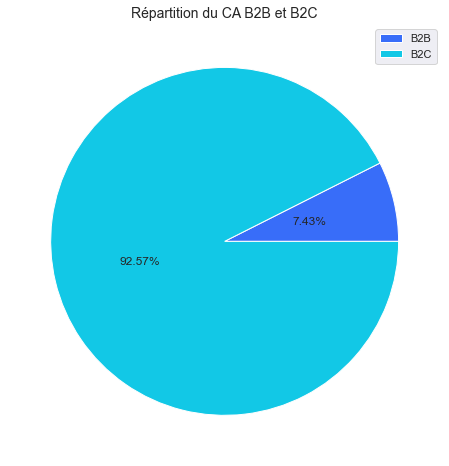

In [17]:
# CA B2B et B2C
df_CA_client_type = df.groupby("client_type").price.sum().reset_index()
plt.figure(figsize=(8, 8))
plt.pie(df_CA_client_type["price"], autopct='%.2f%%', pctdistance=0.5)
plt.title("Répartition du CA B2B et B2C", fontsize=14)
plt.legend(["B2B", "B2C"])
plt.show();

---
---

# 2 - Analyse du CA global

### 2-1 Time series - Evolution du CA

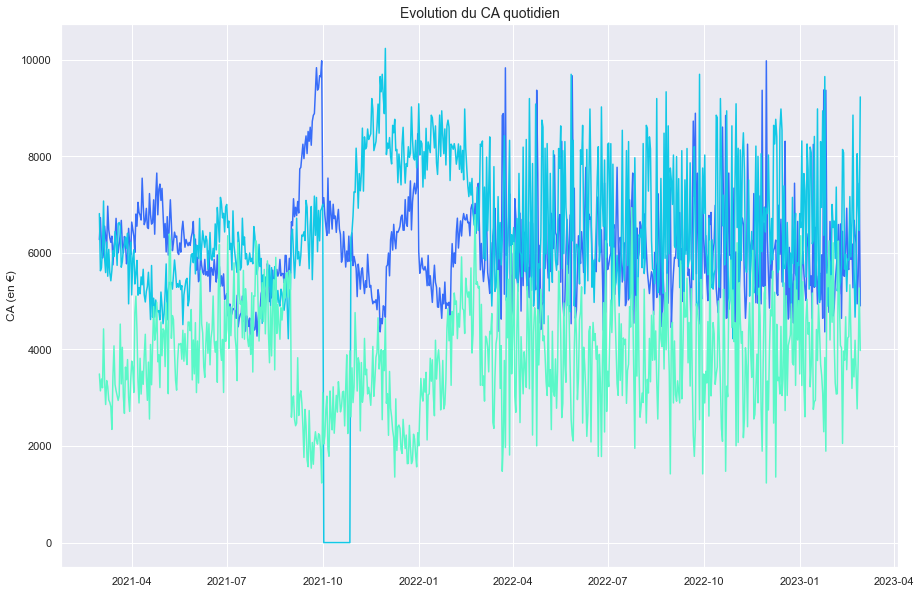

In [18]:
# Evolution du CA quotidien
df_CA_day = df.pivot_table(index="date", columns="categ", values="price", aggfunc="sum")
plt.figure(figsize=(15, 10))
plt.plot(df_CA_day)
plt.title("Evolution du CA quotidien", fontsize=14)
plt.ylabel("CA (en €)")
plt.show();

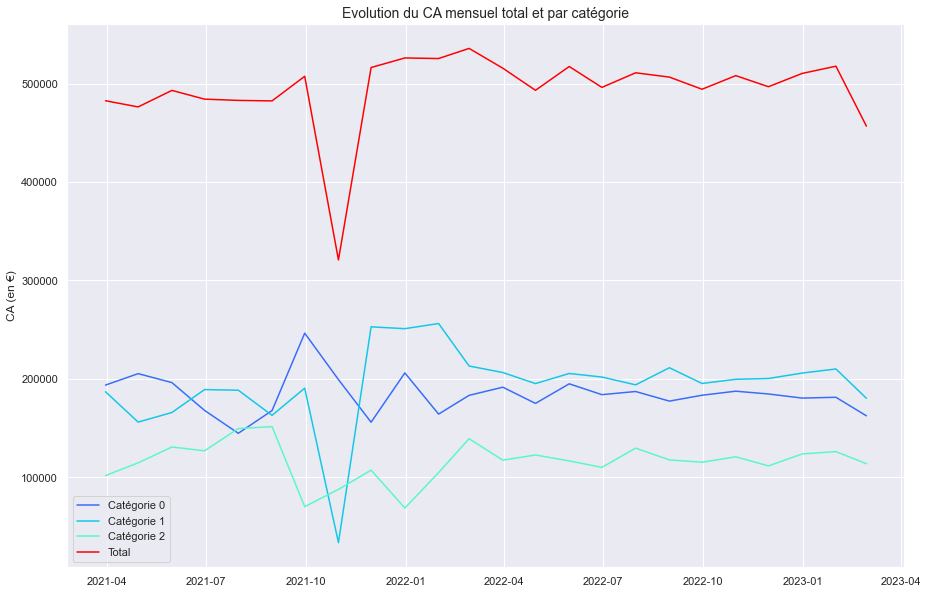

In [19]:
# Evolution du CA mensuel total et par catégorie
period = df["date"].dt.to_period("M")
df_CA_month = df.groupby(period)["price"].sum()

labels = ["Catégorie 0", "Catégorie 1", "Catégorie 2", "Total"]
plt.figure(figsize=(15,10))
plt.plot(df_CA_day.resample("M").sum())
plt.plot(df_CA_month, c="red")
plt.title("Evolution du CA mensuel total et par catégorie", fontsize=14)
plt.ylabel("CA (en €)")
plt.legend(labels)
plt.show();

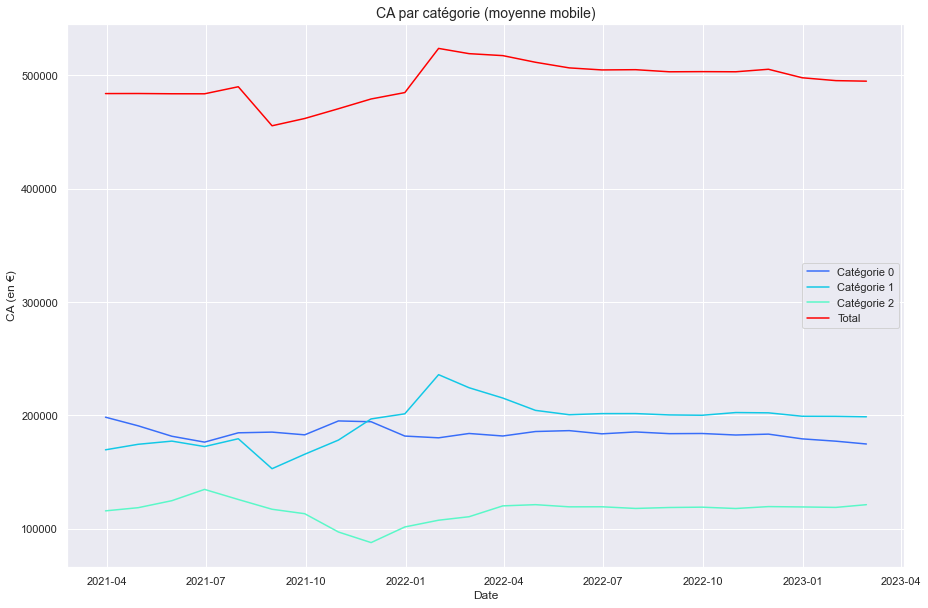

In [20]:
# Décomposition en moyenne mobile centrée (sur 5 mois)
plt.figure(figsize=(15,10))
plt.plot(df_CA_day.resample("M").sum().rolling(window=5, min_periods=1, center=True).mean())
plt.plot(df_CA_month.rolling(window=5, min_periods=1, center=True).mean(), c="red")
plt.title("CA par catégorie (moyenne mobile)", fontsize=14)
plt.legend(labels, loc="center right")
plt.xlabel("Date")
plt.ylabel("CA (en €)")
plt.show();

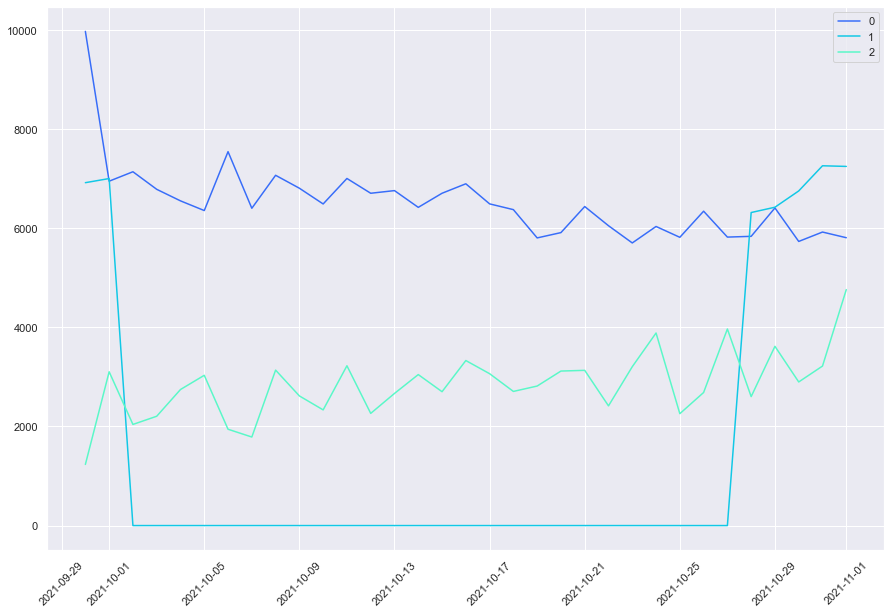

In [21]:
# Zoom sur le mois d'octobre 2021
labels = df_CA_day.columns
plt.figure(figsize=(15,10))
plt.plot(df_CA_day["2021-09-30":"2021-11-01"])
plt.xticks(rotation=45)
plt.legend(labels)
plt.show()

In [22]:
df_CA_day["2021-09-30":"2021-10-29"]

categ            0       1       2
date                              
2021-09-30 9973.95 6920.45 1233.61
2021-10-01 6950.50 7003.79 3104.05
2021-10-02 7141.01    0.00 2041.12
2021-10-03 6786.57    0.00 2206.48
2021-10-04 6553.58    0.00 2746.08
2021-10-05 6357.91    0.00 3032.55
2021-10-06 7546.58    0.00 1944.11
2021-10-07 6404.01    0.00 1787.07
2021-10-08 7069.53    0.00 3137.82
2021-10-09 6808.69    0.00 2616.67
2021-10-10 6490.98    0.00 2334.67
2021-10-11 7005.40    0.00 3225.16
2021-10-12 6706.97    0.00 2264.18
2021-10-13 6760.40    0.00 2666.82
2021-10-14 6422.39    0.00 3047.39
2021-10-15 6707.07    0.00 2701.75
2021-10-16 6898.14    0.00 3330.88
2021-10-17 6492.60    0.00 3065.38
2021-10-18 6376.43    0.00 2707.29
2021-10-19 5805.69    0.00 2816.00
2021-10-20 5912.76    0.00 3118.42
2021-10-21 6438.85    0.00 3132.94
2021-10-22 6051.86    0.00 2416.00
2021-10-23 5704.26    0.00 3206.38
2021-10-24 6036.65    0.00 3886.54
2021-10-25 5817.82    0.00 2258.22
2021-10-26 6345.00    0.00 2685.78
2021-10-27 5822.24    0.00 3967.29
2021-10-28 5837.61 6317.99 2602.82
2021-10-29 6410.57 6425.18 3617.88

Vente à 0 du 2 octobre au 27 ocobre 2021 pour la catégorie 1 ? Explication ? Rupture de stock (qui pourrait expliquer la forte hausse après) ? Inventaire ? Erreur fichier log (a priori non, cf autres catégories) ?  
Supprimer le mois d'octobre ? Extrapoler ?

---

### 2-2 KPI

##### 2-2-1 Comparatif du CA des 2 exercices

Evolution du CA sur les 2 exercices sans correction du mois d'octobre

In [23]:
# Evolution du CA sur les 2 exercices
CA1 = df[df["date"] <= "2022-03-30"]["price"].sum()
CA2 = df[df["date"] > "2022-03-30"]["price"].sum()
taux_evolution = (CA2 - CA1) * 100 / CA1
print(f"Le CA total du 1er exercice est de {CA1:.2f} €,")
print(f"celui du 2ème exercice de : {CA2} €,")
print(f"soit un taux d'évolution de {taux_evolution:.2f} %.")

Le CA total du 1er exercice est de 6332474.91 €,
celui du 2ème exercice de : 5523461.56 €,
soit un taux d'évolution de -12.78 %.


Evolution du CA sur les 2 exercices avec correction du mois d'octobre : suppression des données des 2 mois d'octobre

In [24]:
# Suppression des données des mois d'octobre
df_temp = df[df["purchase_month"] != 10]

In [25]:
CA1 = df_temp[df_temp["date"] <= "2022-03-30"]["price"].sum()
CA2 = df_temp[df_temp["date"] > "2022-03-30"]["price"].sum()
taux_evolution = (CA2 - CA1) * 100 / CA1
print(f"Le CA total du 1er exercice est de {CA1:.2f} €,")
print(f"celui du 2ème exercice de : {CA2} €,")
print(f"soit un taux d'évolution de {taux_evolution:.2f} %.")

Le CA total du 1er exercice est de 6011606.24 €,
celui du 2ème exercice de : 5015443.89 €,
soit un taux d'évolution de -16.57 %.


Evolution du CA par catégorie sur les 2 exercices avec correction du mois d'octobre

In [26]:
df_temp1 = df_temp[df_temp["date"] <= "2022-03-30"].groupby("categ")["price"].sum().reset_index()
df_temp2 = df_temp[df_temp["date"] > "2022-03-30"].groupby("categ")["price"].sum().reset_index()
(df_temp2["price"] - df_temp1["price"]) * 100 / df_temp1["price"]

0   -18.05
1   -16.87
2   -13.67
Name: price, dtype: float64

##### 2-2-2 Analyse B2C

Etude sur la période globale, pas de focus sur une année en particulier.

In [27]:
# CA B2C
CA_b2c = df_b2c["price"].sum()
print(f"Le CA B2C total est de {CA_b2c:.2f} € pour les 2 exercices.")

Le CA B2C total est de 10974816.02 € pour les 2 exercices.


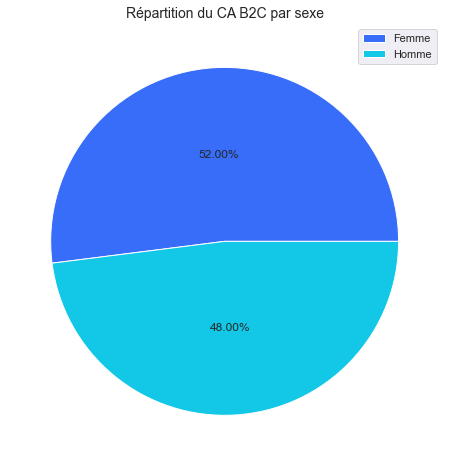

In [28]:
# CA B2C par sexe
df_b2c_sex = df_b2c.groupby("sex").price.sum().reset_index()
plt.figure(figsize=(8, 8))
plt.pie(df_b2c_sex["price"], autopct='%.2f%%', pctdistance=0.5)
plt.title("Répartition du CA B2C par sexe", fontsize=14)
plt.legend(["Femme", "Homme"])
plt.show();

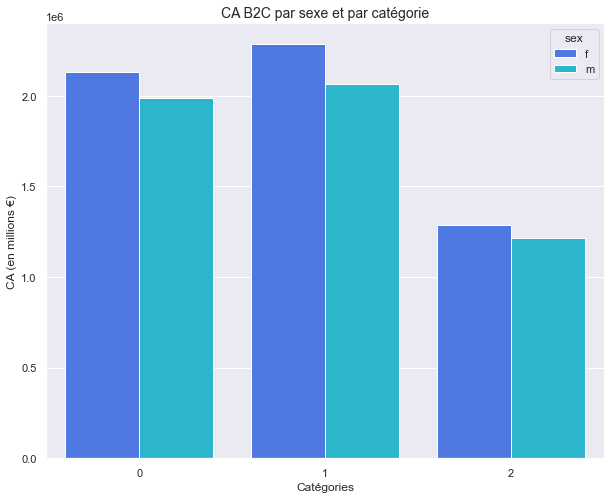

In [29]:
# CA B2C par sexe et catégorie
df_b2c_sex_categ = df_b2c.groupby(["sex", "categ"]).price.sum().reset_index()
plt.figure(figsize=(10, 8))
sns.barplot(x="categ", y="price", hue="sex", data=df_b2c_sex_categ)
plt.title("CA B2C par sexe et par catégorie", fontsize=14)
plt.ylabel("CA (en millions €)")
plt.xlabel("Catégories")
plt.show()

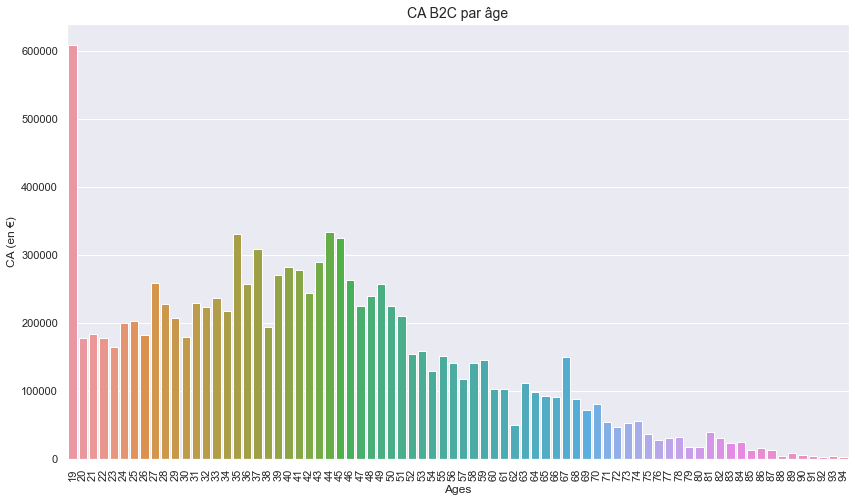

In [30]:
# CA B2C par âge
df_b2c_age = df_b2c.groupby("age").price.sum().reset_index()
plt.figure(figsize=(14, 8))
sns.barplot(x="age", y="price", data=df_b2c_age)
plt.title("CA B2C par âge", fontsize=14)
plt.ylabel("CA (en €)")
plt.xlabel("Ages")
plt.xticks(rotation=90)
plt.show()

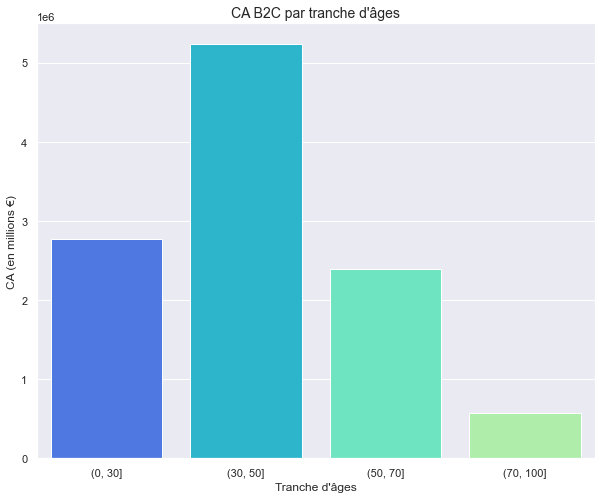

In [31]:
# CA B2C par tranche d'âges
df_b2c["int_age"] = pd.cut(df_b2c["age"], bins=[0, 30, 50, 70, 100])
df_b2c_age = df_b2c.groupby("int_age").price.sum().reset_index()
plt.figure(figsize=(10, 8))
sns.barplot(x="int_age", y="price", data=df_b2c_age)
plt.title("CA B2C par tranche d'âges", fontsize=14)
plt.ylabel("CA (en millions €)")
plt.xlabel("Tranche d'âges")
plt.show()

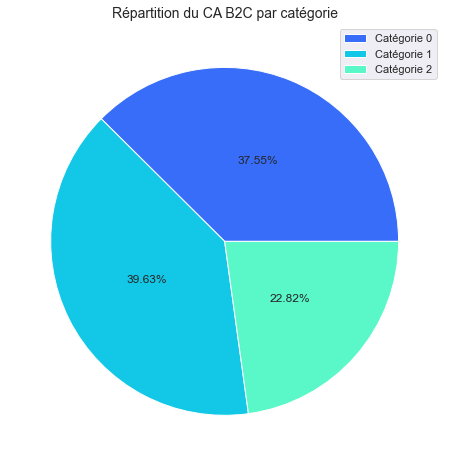

In [32]:
# CA B2C par catégorie
df_b2c_categ = df_b2c.groupby("categ").price.sum().reset_index()
plt.figure(figsize=(8, 8))
plt.pie(df_b2c_categ["price"], autopct='%.2f%%', pctdistance=0.5)
plt.title("Répartition du CA B2C par catégorie", fontsize=14)
plt.legend(["Catégorie 0", "Catégorie 1", "Catégorie 2"])
plt.show();

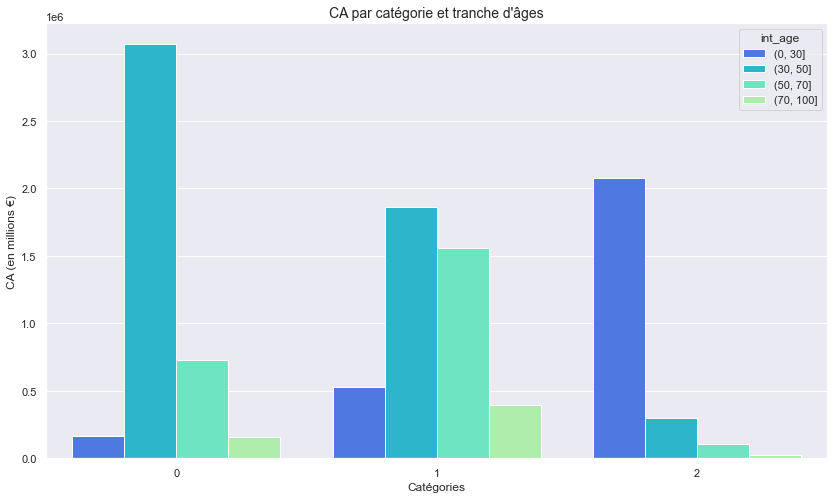

In [33]:
# CA par catégorie et tranche d'âges
df_b2c_categ_age = df_b2c.groupby(["categ", "int_age"]).price.sum().reset_index()
plt.figure(figsize=(14, 8))
sns.barplot(x="categ", y="price", hue="int_age", data=df_b2c_categ_age)
plt.title("CA par catégorie et tranche d'âges", fontsize=14)
plt.ylabel("CA (en millions €)")
plt.xlabel("Catégories")
plt.show()

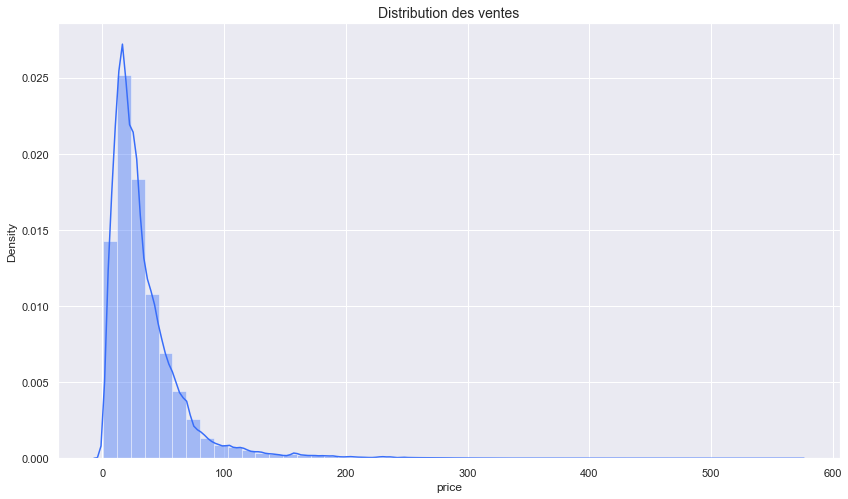

In [34]:
# Analyse des ventes
df_b2c_avg_spent = df_b2c.groupby("session_id")["price"].sum().reset_index()
plt.figure(figsize=(14, 8))
sns.distplot(df_b2c_avg_spent["price"], bins=50)
plt.title("Distribution des ventes", fontsize=14)
plt.show();

In [35]:
# Analyse du panier moyen
panier_moyen = df_b2c.groupby("session_id")["price"].mean().mean()
panier_article = df_b2c.groupby("session_id")["price"].count().mean()
print(f"Le montant du panier moyen est de {panier_moyen:.2f} € avec une moyenne de {panier_article:.2f} articles par panier.")

Le montant du panier moyen est de 18.99 € avec une moyenne de 1.98 articles par panier.


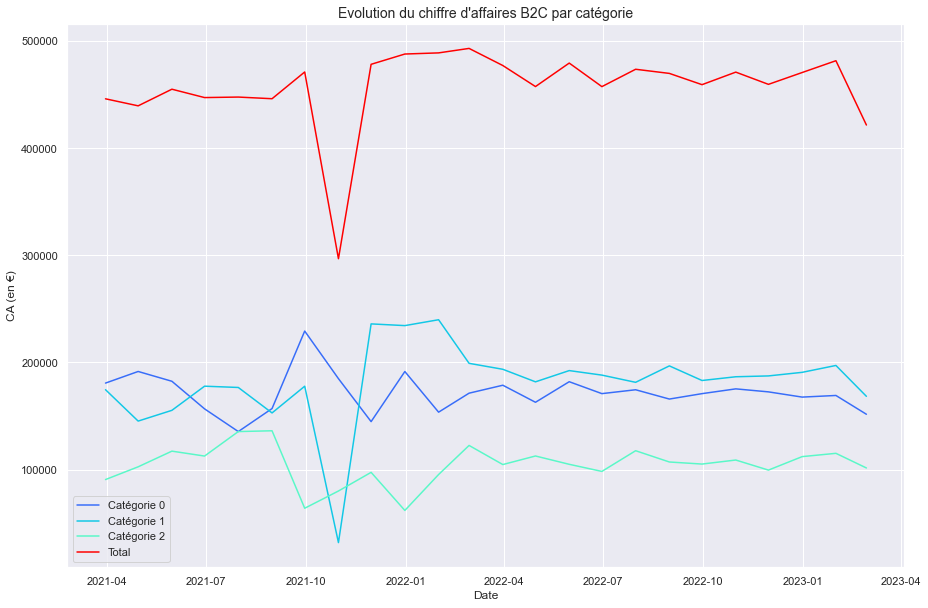

In [36]:
# Evolution du CA B2C mensuel
period = df_b2c["date"].dt.to_period("M")
df_b2c_CA_per_month = df_b2c.groupby(period)["price"].sum()
df_temp = df_b2c.pivot_table(index="date", columns="categ", values="price", aggfunc="sum")
labels = ["Catégorie 0", "Catégorie 1", "Catégorie 2", "Total", "Moyenne mobile"]
plt.figure(figsize=(15,10))
plt.plot(df_temp.resample("M").sum())
plt.plot(df_b2c_CA_per_month, c="red")
plt.title("Evolution du chiffre d'affaires B2C par catégorie", fontsize=14)
plt.xlabel("Date")
plt.ylabel("CA (en €)")
plt.legend(labels)
plt.show();

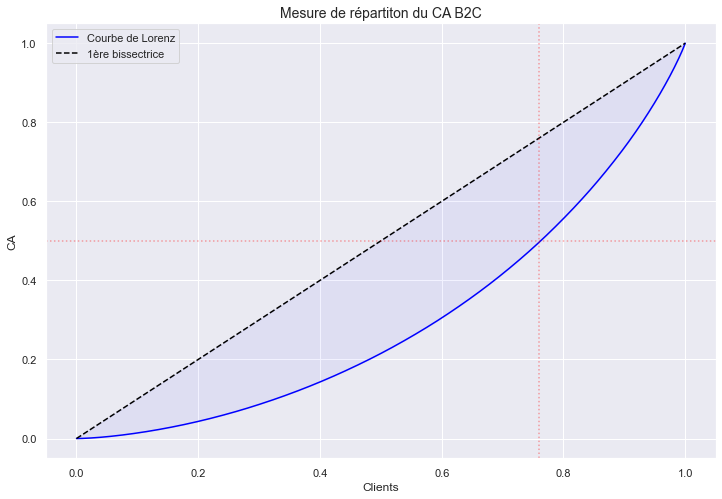

In [37]:
# Répartition du CA B2C - Courbe de Lorenz
df_b2c_CA_client = df_b2c.groupby("client_id")["price"].sum().reset_index().sort_values("price")
df_b2c_CA_client.reset_index(inplace=True, drop=True)
x = df_b2c_CA_client.index + 1
y = df_b2c_CA_client["price"].cumsum()

plt.figure(figsize=(12, 8))
plt.plot(x/max(x), y/max(y), c="blue", label="Courbe de Lorenz")
plt.plot(x/max(x), x/max(x), c="black", ls="--", label="1ère bissectrice")
plt.axhline(y=0.5, c="red", ls=":", alpha=0.35)
plt.axvline(x=0.76, c="red", ls=":", alpha=0.35)
plt.title("Mesure de répartiton du CA B2C", fontsize=14)
plt.xlabel("Clients")
plt.ylabel("CA")
plt.legend()
plt.fill_between(x/max(x), y/max(y), x/max(x), color="blue", alpha=0.05)
plt.show()

In [38]:
gini(y)

Gini value: 0.5034


25% des clients effectuent 50% du CA

##### 2-2-3 Analyse B2B

In [39]:
# CA B2B
CA_b2b = df_b2b["price"].sum()
print(f"Le CA B2B total est de {CA_b2b:.2f} € pour les 2 exercices.")

Le CA B2B total est de 881120.45 € pour les 2 exercices.


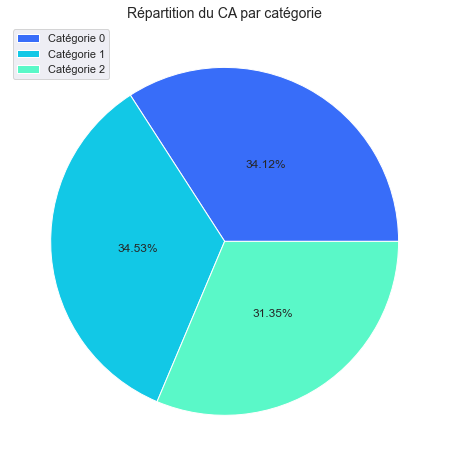

In [40]:
# CA par catégorie
df_b2b_categ = df_b2b.groupby("categ").price.sum().reset_index()
plt.figure(figsize=(8, 8))
plt.pie(df_b2b_categ["price"], autopct='%.2f%%', pctdistance=0.5)
plt.title("Répartition du CA par catégorie", fontsize=14)
plt.legend(["Catégorie 0", "Catégorie 1", "Catégorie 2"])
plt.show();

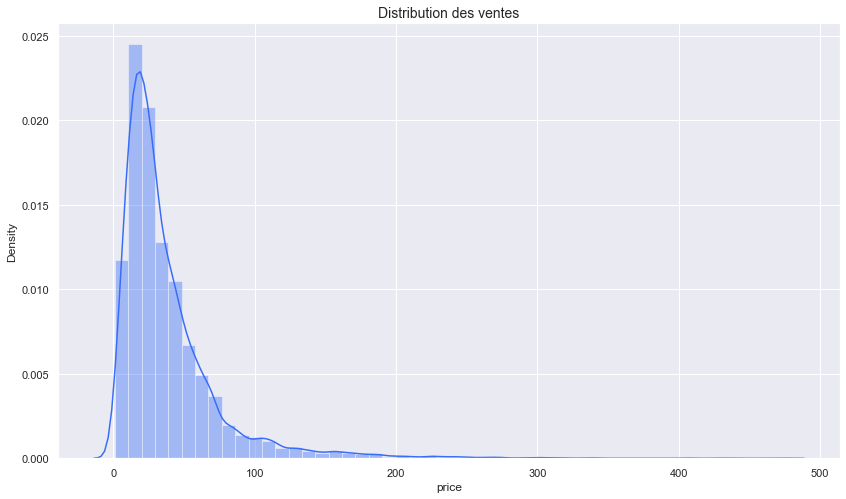

In [41]:
# Analyse des ventes
df_b2b_avg_spent = df_b2b.groupby("session_id")["price"].sum().reset_index()
plt.figure(figsize=(14, 8))
sns.distplot(df_b2b_avg_spent["price"], bins=50)
plt.title("Distribution des ventes", fontsize=14)
plt.show();

In [42]:
# Analyse du panier moyen
panier_moyen = df_b2b.groupby("session_id")["price"].mean().mean()
panier_article = df_b2b.groupby("session_id")["price"].count().mean()
print(f"Le montant du panier moyen est de {panier_moyen:.2f} € avec une moyenne de {panier_article:.2f} articles par panier.")

Le montant du panier moyen est de 21.36 € avec une moyenne de 2.02 articles par panier.


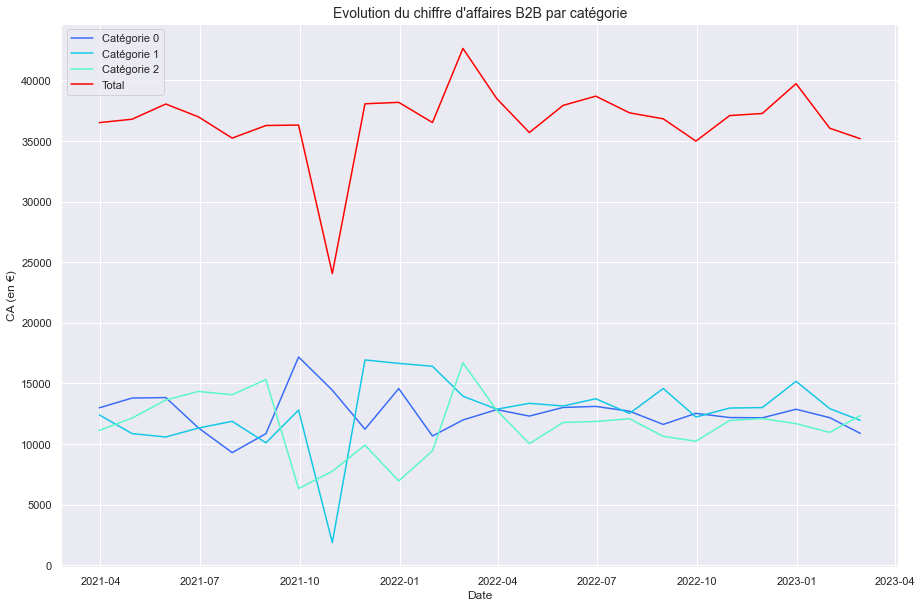

In [43]:
# Evolution du CA B2B mensuel
period = df_b2b["date"].dt.to_period("M")
df_b2b_CA_per_month = df_b2b.groupby(period)["price"].sum()
df_temp = df_b2b.pivot_table(index="date", columns="categ", values="price", aggfunc="sum")
labels = ["Catégorie 0", "Catégorie 1", "Catégorie 2", "Total", "Moyenne mobile"]
plt.figure(figsize=(15,10))
plt.plot(df_temp.resample("M").sum())
plt.plot(df_b2b_CA_per_month, c="red")
plt.title("Evolution du chiffre d'affaires B2B par catégorie", fontsize=14)
plt.xlabel("Date")
plt.ylabel("CA (en €)")
plt.legend(labels)
plt.show();

##### 2-2-4 Top/flop des ventes

In [44]:
# Liste des 21 références invendues
df_invendu = pd.read_pickle("data/df_invendu.pkl")
df_invendu.sample(21)

id_prod date session_id client_id time  price categ      _merge
679351   0_510  NaT        NaN       NaN  NaN  23.66     0  right_only
679348  0_1624  NaT        NaN       NaN  NaN  24.50     0  right_only
679350   0_299  NaT        NaN       NaN  NaN  22.99     0  right_only
679346    2_72  NaT        NaN       NaN  NaN 141.32     2  right_only
679336  0_1014  NaT        NaN       NaN  NaN   1.15     0  right_only
679345   1_394  NaT        NaN       NaN  NaN  39.73     1  right_only
679338  0_1318  NaT        NaN       NaN  NaN  20.92     0  right_only
679342  0_1620  NaT        NaN       NaN  NaN   0.80     0  right_only
679347   0_310  NaT        NaN       NaN  NaN   1.94     0  right_only
679341   0_322  NaT        NaN       NaN  NaN   2.99     0  right_only
679343  0_1025  NaT        NaN       NaN  NaN  24.99     0  right_only
679333  0_1780  NaT        NaN       NaN  NaN   1.67     0  right_only
679349    2_86  NaT        NaN       NaN  NaN 132.36     2  right_only
679332  0_1016  NaT        NaN       NaN  NaN  35.06     0  right_only
679352  0_2308  NaT        NaN       NaN  NaN  20.28     0  right_only
679344    2_87  NaT        NaN       NaN  NaN 220.99     2  right_only
679339  0_1800  NaT        NaN       NaN  NaN  22.05     0  right_only
679340  0_1645  NaT        NaN       NaN  NaN   2.99     0  right_only
679334  0_1062  NaT        NaN       NaN  NaN  20.08     0  right_only
679335  0_1119  NaT        NaN       NaN  NaN   2.99     0  right_only
679337     1_0  NaT        NaN       NaN  NaN  31.82     1  right_only

In [45]:
# Nombre d'invendus par catégorie
df_invendu.groupby("categ")["id_prod"].count()

categ
0    16
1     2
2     3
Name: id_prod, dtype: int64

In [46]:
# Top 10 des ventes B2C (CA)
df_b2c_top_CA = df_b2c.groupby(["id_prod", "categ"])["price"].sum().reset_index()
df_b2c_top_CA.rename(columns={"price": "CA"}, inplace=True)
df_b2c_top_CA.sort_values("CA", ascending=False).head(10)

id_prod categ       CA
9284   2_159     2 91097.76
9206   2_135     2 63470.80
9134   2_112     2 58785.90
9101   2_102     2 55650.74
7771   1_369     1 50834.81
9452   2_209     2 50742.75
7855   1_395     1 49949.77
7921   1_414     1 48803.84
9308   2_166     2 48308.40
9128   2_110     2 47870.25

Absence de la catégorie 0 dans le top 10

In [47]:
# Top 10 des ventes B2C (nombre de ventes)
df_b2c_top_nb_vente = df_b2c.groupby(["id_prod", "categ"])["price"].count().reset_index()
df_b2c_top_nb_vente.rename(columns={"price": "Nombre de ventes"}, inplace=True)
df_b2c_top_nb_vente.sort_values("Nombre de ventes", ascending=False).head(10)

id_prod categ  Nombre de ventes
7771   1_369     1              2119
7921   1_414     1              2048
7930   1_417     1              2048
8197   1_498     1              1969
7957   1_425     1              1961
7915   1_412     1              1853
7918   1_413     1              1846
7897   1_407     1              1818
7894   1_406     1              1805
7858   1_396     1              1800

Seule la catégorie 1 dans le top 10 (nombre de ventes)

---
---

# 3 - Corrélations et dépendances

Suppression des données du mois d'octobre 2021 pour les 3 catégories pour éviter tous biais dans l'analyse des corrélations et des dépendances.  
Cette analyse ne sera faite que sur les données B2C et sur toute la période (2 années de données).

In [48]:
# Suppression des données d'octobre 2021
df_b2c_corr = df_b2c[(df_b2c["date"] < "2021-10-01") | (df_b2c["date"] > "2021-10-30")]

### 3-1 Analyse de la distributon des variables quantitatives

Afin de déterminer les tests statistiques (paramétriques ou non) à utiliser lors de notre analyse, il faut vérifier si nos variables quantitatives suivent une loi normale.

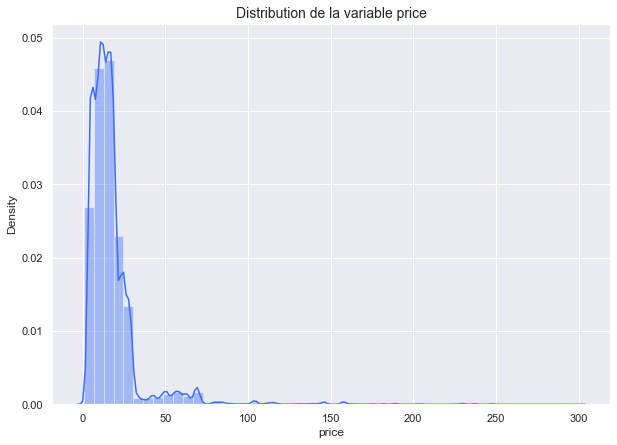

In [49]:
# Variable price
plt.figure(figsize=(10, 7))
sns.distplot(df_b2c_corr["price"])
plt.title("Distribution de la variable price", fontsize=14)
plt.show();

In [50]:
# Test de Shapiro (loi normale)
# H0 : suit une loi normale

stat, p = shapiro(df_b2c_corr["price"])
print(f"Test-Statistic = {stat:.3f} , p-value = {p:.10f}")

Test-Statistic = 0.549 , p-value = 0.0000000000


H0 rejetée, distribution ne suivant pas une loi normale.

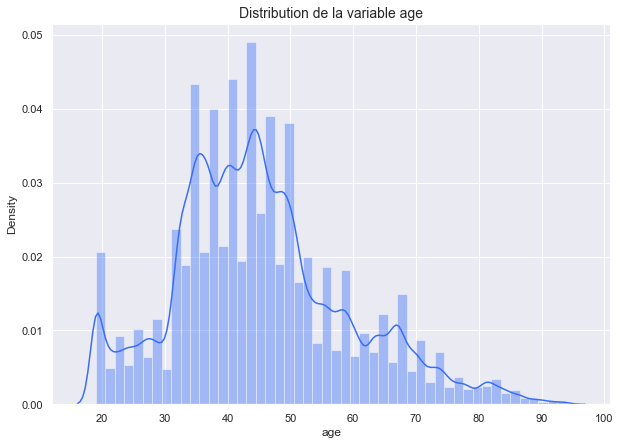

In [51]:
# Variable age
plt.figure(figsize=(10, 7))
sns.distplot(df_b2c_corr["age"])
plt.title("Distribution de la variable age", fontsize=14)
plt.show();

In [52]:
# Test de Shapiro (loi normale)
# H0 : suit une loi normale

stat, p = shapiro(df_b2c_corr["age"])
print(f"Test-Statistic = {stat:.3f} , p-value = {p:.10f}")

Test-Statistic = 0.972 , p-value = 0.0000000000


H0 rejetée, distribution ne suivant pas une loi normale.

Nos 2 variables quantitatives ne suivant pas une distribution gaussienne, il faudra utiliser un test non paramétriques - test Kruskal-Wallis - et/ou discrétiser cette variable pour effectuer un test Chi2.

### 3-2 Analyse de la variable categ

##### 3-2-1 categ et price

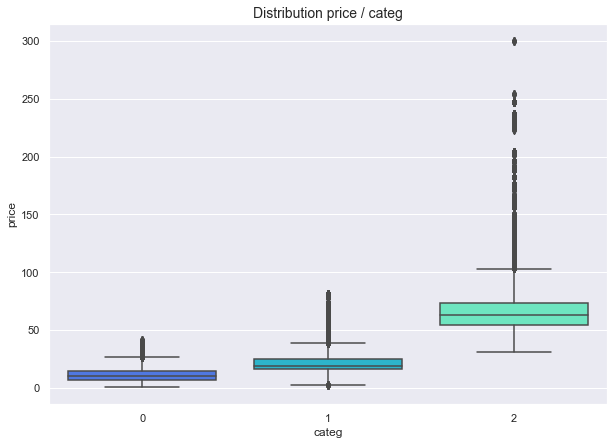

In [53]:
# Boxplot
plt.figure(figsize=(10, 7))
sns.boxplot(x="categ", y="price", data=df_b2c_corr)
plt.title("Distribution price / categ", fontsize=14)
plt.show();

Visuellement, les catégories semblent avoir une gamme de prix différents.

Variable qualitative / variable quantitative  
La variable price ne suivant pas une loi normale, il s'agit d'effectuer un test Kruskal-Wallis plutôt qu'un test ANOVA.

In [54]:
# test Kruskal-Wallis
kstat, pval = stats.kruskal(*[group["price"].values for name, group in df_b2c_corr.groupby("categ")])
print(pval)

0.0


On peut donc supposer qu'au moins une des 3 catégories diffère des autres par le prix... Ce qui confirme notre intuition visuelle.

Discrétisons la variable prix (selon la méthode des quartiles - un même nombre d'individus dans chaque intervalle) et effectuons un test Chi2.

In [55]:
df_b2c_corr["int_price"] = pd.qcut(df_b2c_corr["price"], 4)

In [56]:
# Test Chi2
df_int_price_categ = pd.crosstab(df_b2c_corr["int_price"], df_b2c_corr["categ"])
Khi2_obs, p_value, ddl, effectif_theorique = chi2_contingency(df_int_price_categ)
p_value

0.0

In [57]:
# Méthode Cramer V. pour mesurer la force de cette dépendance (0 - faible à 1 - forte)
cramers_v(df_b2c_corr["int_price"], df_b2c_corr["categ"])

0.508988136007821

Dépendance confirmée entre int_price et categ.

##### 3-2-2 categ et sex

2 variables qualitatives, test Chi2

In [58]:
# Test Chi2
df_categ_sex = pd.crosstab(df_b2c_corr["categ"], df_b2c_corr["sex"])
Khi2_obs, p_value, ddl, effectif_theorique = chi2_contingency(df_categ_sex)
p_value

0.00010114035908099157

In [59]:
# Méthode Cramer's V. pour mesurer la force de cette dépendance (0 - faible à 1 - forte)
cramers_v(df_b2c_corr["sex"], df_b2c_corr["categ"])

0.005169866166518467

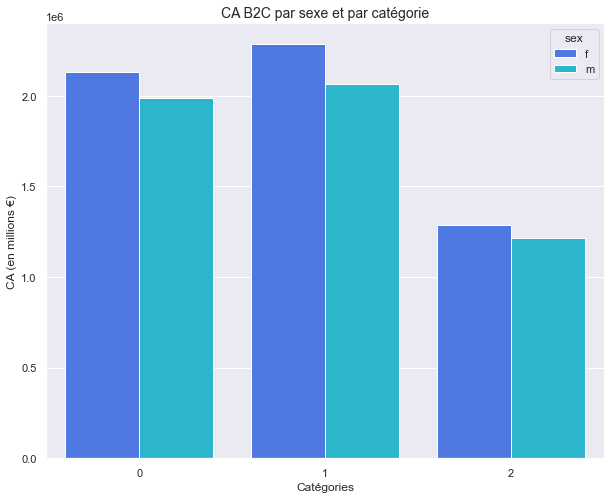

In [60]:
plt.figure(figsize=(10, 8))
sns.barplot(x="categ", y="price", hue="sex", data=df_b2c_sex_categ)
plt.title("CA B2C par sexe et par catégorie", fontsize=14)
plt.ylabel("CA (en millions €)")
plt.xlabel("Catégories")
plt.show()

Dépendance très faible entre sex et categ, probablement due à une plus grande consommation (proportionnellement à la distribution H/F) des hommes pour la catégorie 2 et une plus grande consommation (proportionnellement) des femmes de la catégorie 1.

##### 3-2-3 categ et age

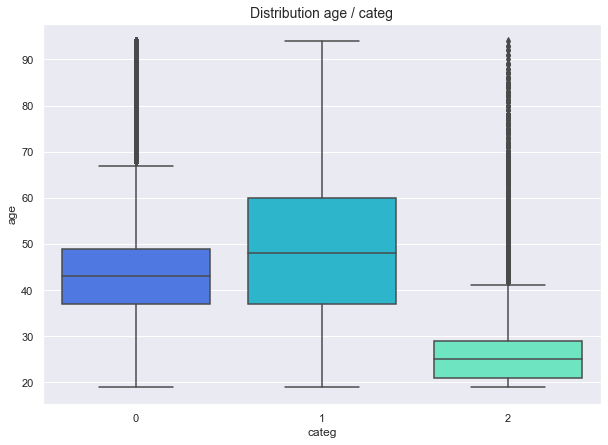

In [61]:
# Boxplot
plt.figure(figsize=(10, 7))
sns.boxplot(x="categ", y="age", data=df_b2c_corr)
plt.title("Distribution age / categ", fontsize=14)
plt.show();

Visuellement, les catégories semblent intéresser des personnes d'âges différents.

Variable qualitative / variable quantitative  
La variable age ne suivant pas une loi normale, il s'agit d'effectuer un test Kruskal-Wallis plutôt qu'un test ANOVA.

In [62]:
# test Kruskal-Wallis
kstat, pval = stats.kruskal(*[group["age"].values for name, group in df_b2c_corr.groupby("categ")])
print(pval)

0.0


On peut donc supposer qu'au moins une des 3 catégories diffère des autres par l'âge... Ce qui confirme notre intuition visuelle.

Vérifions cela avec le test Chi2 en utilisant int_age plutôt qu'age.

In [63]:
# Test Chi2
df_int_price_categ = pd.crosstab(df_b2c_corr["int_age"], df_b2c_corr["categ"])
Khi2_obs, p_value, ddl, effectif_theorique = chi2_contingency(df_int_price_categ)
p_value

0.0

In [64]:
# Méthode Cramer's V. pour mesurer la force de cette dépendance (0 - faible à 1 - forte)
cramers_v(df_b2c_corr["int_age"], df_b2c_corr["categ"])

0.4414741092966617

La catégorie 2 est particulièrement plébiscitée par les jeunes adultes, la catégorie 0 par les adultes et la catégorie 1 par les adultes et séniors.

### 3-3 Analyse de la variable age

##### 3-3-1 Age et montant total des achats

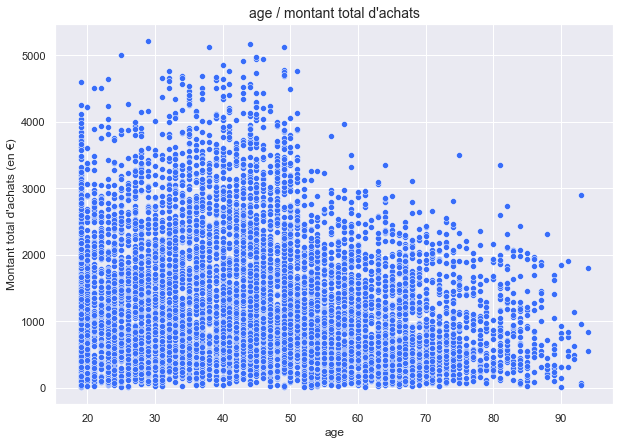

In [65]:
df_CA_age = df_b2c_corr.groupby(["client_id", "age"])["price"].sum().reset_index()
plt.figure(figsize=(10, 7))
sns.scatterplot(df_CA_age["age"], df_CA_age["price"])
plt.title("age / montant total d'achats", fontsize=14)
plt.ylabel("Montant total d'achats (en €)")
plt.show();

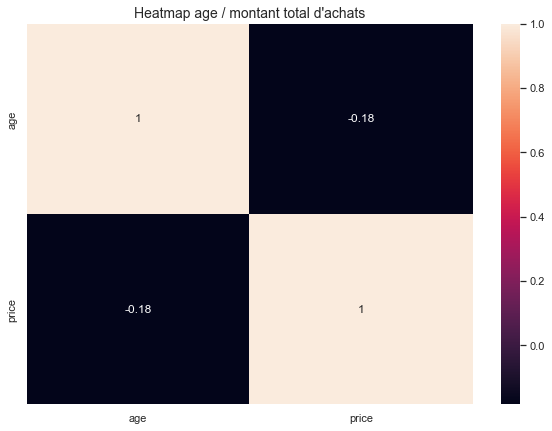

In [66]:
plt.figure(figsize=(10, 7))
sns.heatmap(df_CA_age.corr(), annot=True)
plt.title("Heatmap age / montant total d'achats", fontsize=14)
plt.show();

Très faible corrélation négative entre l'âge et les dépenses totales effectuées sur le site ecommerce.

##### 3-3-2 Age et fréquence d'achats

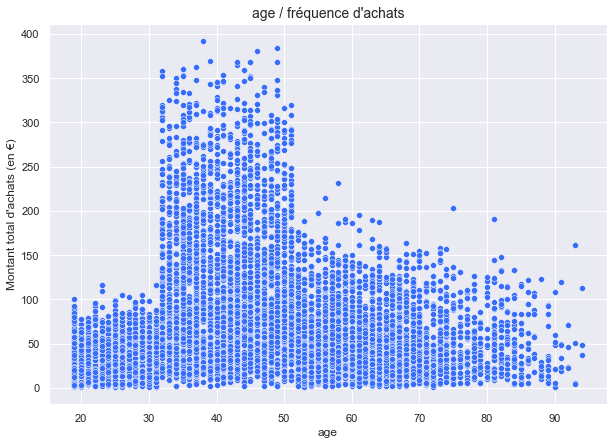

In [67]:
df_CA_freq_age = df_b2c_corr.groupby(["client_id", "age"])["price"].count().reset_index()
plt.figure(figsize=(10, 7))
sns.scatterplot(df_CA_freq_age["age"], df_CA_freq_age["price"])
plt.title("age / fréquence d'achats", fontsize=14)
plt.ylabel("Montant total d'achats (en €)")
plt.show();

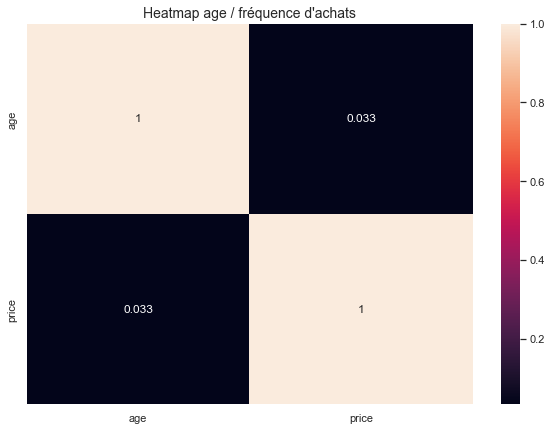

In [68]:
plt.figure(figsize=(10, 7))
sns.heatmap(df_CA_freq_age.corr(), annot=True)
plt.title("Heatmap age / fréquence d'achats", fontsize=14)
plt.show();

Corrélation quasiment nulle entre l'âge et le montant d'achat.

##### 3-3-3 Age et panier moyen

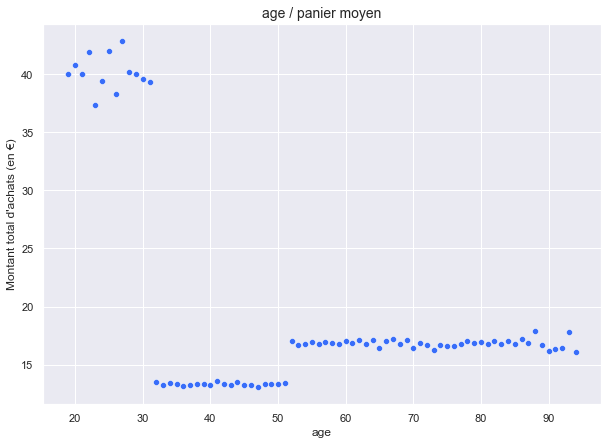

In [69]:
df_age_panier_moyen = df_b2c_corr.groupby(["age"])["price"].mean().reset_index()
plt.figure(figsize=(10, 7))
sns.scatterplot(df_age_panier_moyen["age"], df_age_panier_moyen["price"])
plt.title("age / panier moyen", fontsize=14)
plt.ylabel("Montant total d'achats (en €)")
plt.show();

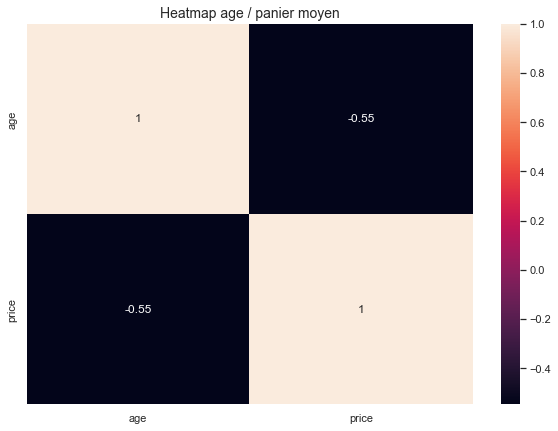

In [70]:
plt.figure(figsize=(10, 7))
sns.heatmap(df_age_panier_moyen.corr(), annot=True)
plt.title("Heatmap age / panier moyen", fontsize=14)
plt.show();

Corrélation négative moyenne.   
Le panier moyen des jeunes adultes est très nettement supérieur à celui de l'ensemble de la clientèle (autour de 40 €). Les adultes dépensent moins de 10€ en moyenne tandis que le panier moyen des séniors est entre 15 et 20 €.

##### 3-3-4 Age et taille du panier moyen

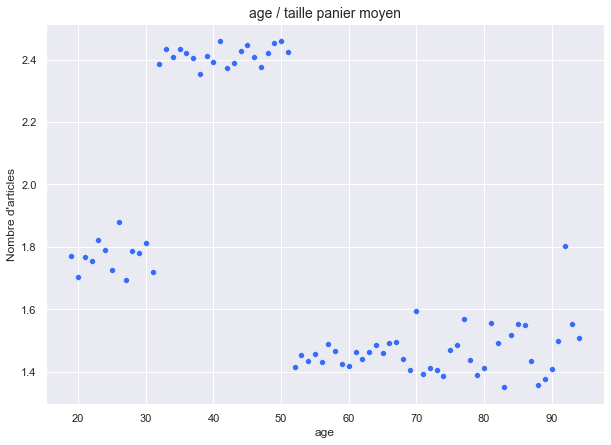

In [71]:
df_temp = df_b2c_corr.groupby(["session_id", "client_id", "age"])["price"].count().reset_index()
df_taille_panier = df_temp.groupby("age")["price"].mean().reset_index()
plt.figure(figsize=(10, 7))
sns.scatterplot(df_taille_panier["age"], df_taille_panier["price"])
plt.title("age / taille panier moyen", fontsize=14)
plt.ylabel("Nombre d'articles")
plt.show();

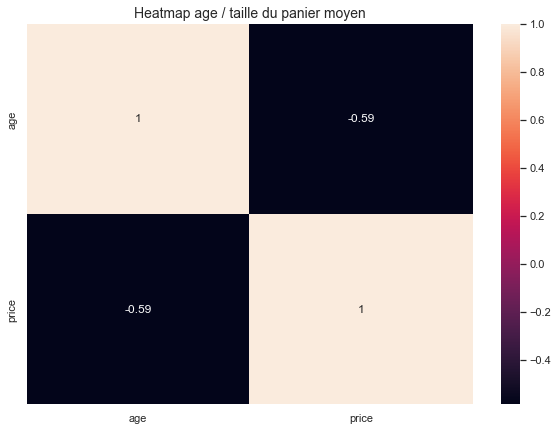

In [72]:
plt.figure(figsize=(10, 7))
sns.heatmap(df_taille_panier.corr(), annot=True)
plt.title("Heatmap age / taille du panier moyen", fontsize=14)
plt.show();

Corrélation négative. Les jeunes adultes achètent en moyenne 1,8 articles, les adultes 2,4 et les séniors autour de 1,5.

##### 3-3-5 Age et nombre d'achats

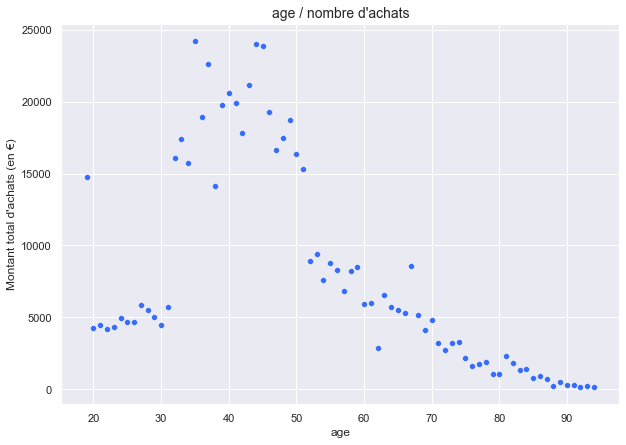

In [73]:
df_age_nb_achat = df_b2c_corr.groupby(["age"])["price"].count().reset_index()
plt.figure(figsize=(10, 7))
sns.scatterplot(df_age_nb_achat["age"], df_age_nb_achat["price"])
plt.title("age / nombre d'achats", fontsize=14)
plt.ylabel("Montant total d'achats (en €)")
plt.show();

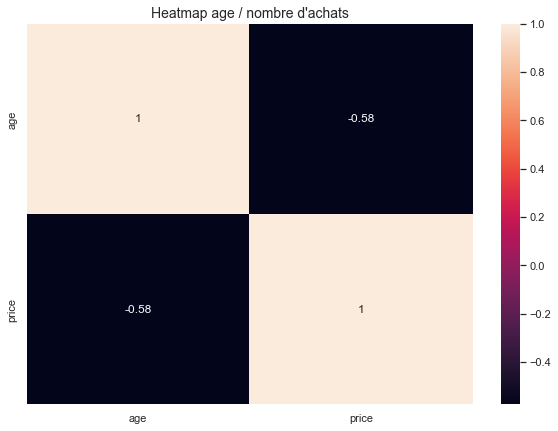

In [74]:
plt.figure(figsize=(10, 7))
sns.heatmap(df_age_nb_achat.corr(), annot=True)
plt.title("Heatmap age / nombre d'achats", fontsize=14)
plt.show();

Corrélation négative moyenne. Les jeunes adultes effectuent peu d'achats (avec un panier moyen élevé), les adultes beaucoup d'achats (avec un panier moyen faible). Le nombre d'achats des séniors diminuent avec l'âge.

---
---
---

# Divers

### Featuring

In [75]:
# Ajout Panier moyen
df_age_panier_moyen.rename(columns={"price": "avg_basket"}, inplace=True)
df_temp = df_b2c_corr.merge(df_age_panier_moyen, on="age")

In [76]:
# Ajout Taille panier moyen
df_taille_panier.rename(columns={"price": "nb_basket"}, inplace=True)
df_featuring = df_temp.merge(df_taille_panier, on="age")

In [77]:
# get_dummies - to "quantitive" sex and variables
df_featuring1 = pd.get_dummies(df_featuring, columns=["sex", "categ"])

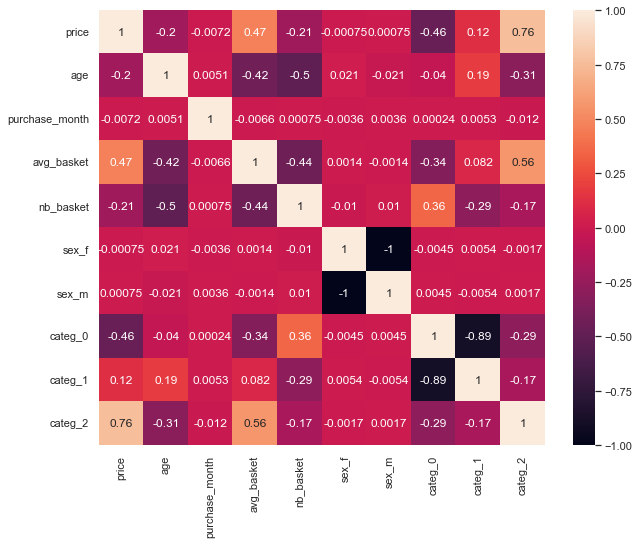

In [78]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_featuring1.corr(), annot=True)
plt.show();

In [79]:
df_featuring2 = pd.get_dummies(df_featuring, columns=["sex", "categ"], drop_first=True)

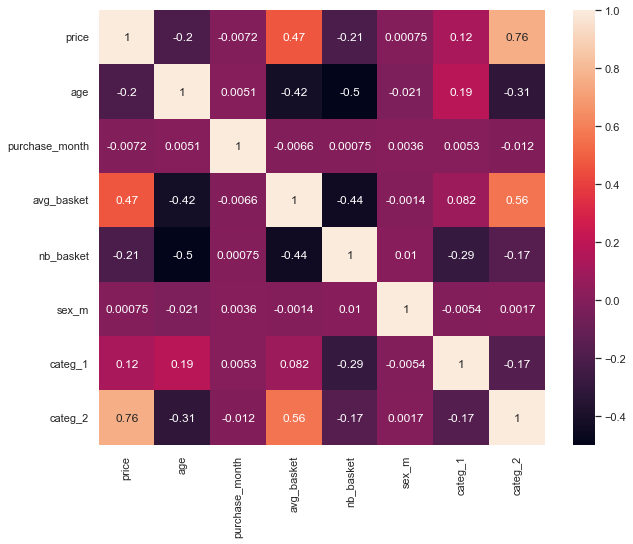

In [80]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_featuring2.corr(), annot=True)
plt.show();

In [81]:
df_featuring2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 613526 entries, 0 to 613525
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id_prod         613526 non-null  object        
 1   date            613526 non-null  datetime64[ns]
 2   session_id      613526 non-null  object        
 3   client_id       613526 non-null  object        
 4   time            613526 non-null  object        
 5   price           613526 non-null  float64       
 6   age             613526 non-null  int64         
 7   purchase_month  613526 non-null  int64         
 8   client_type     613526 non-null  object        
 9   int_age         613526 non-null  category      
 10  int_price       613526 non-null  category      
 11  avg_basket      613526 non-null  float64       
 12  nb_basket       613526 non-null  float64       
 13  sex_m           613526 non-null  uint8         
 14  categ_1         613526 non-null  uin

**Clustering de la clientèle**

In [82]:
col = ["price", "age", "purchase_month", "avg_basket", "nb_basket", "sex_m", "categ_1", "categ_2"]
df_cluster = df_featuring2[col]

In [84]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [85]:
X = df_cluster
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

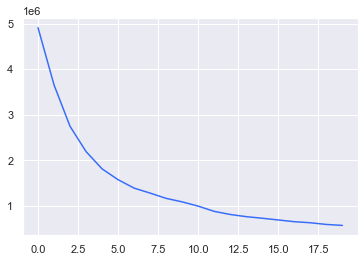

In [86]:
# Elbow graph
ssd = []
for num_clusters in list(range(1,21)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=100)
    model_clus.fit(X_scaled)
    ssd.append(model_clus.inertia_)

plt.plot(ssd);

In [87]:
# On retient 5 groupes
model = KMeans(init="random", n_clusters=5, n_init=10, max_iter=300, random_state=42)

In [88]:
model.fit(X_scaled)

KMeans(init='random', n_clusters=5, random_state=42)

In [89]:
X.index = pd.RangeIndex(len(X.index))
X_km = pd.concat([X, pd.Series(model.labels_)], axis=1)
X_km.rename(columns={0: "cluster"}, inplace=True)
X_km.head()

price  age  purchase_month  avg_basket  nb_basket  sex_m  categ_1  categ_2  \
0   4.18   37               5       13.25       2.40      0        0        0   
1   4.18   37               7       13.25       2.40      0        0        0   
2   4.18   37               8       13.25       2.40      0        0        0   
3   8.57   37               6       13.25       2.40      0        0        0   
4   8.57   37               8       13.25       2.40      0        0        0   

   cluster  
0        1  
1        1  
2        1  
3        1  
4        1

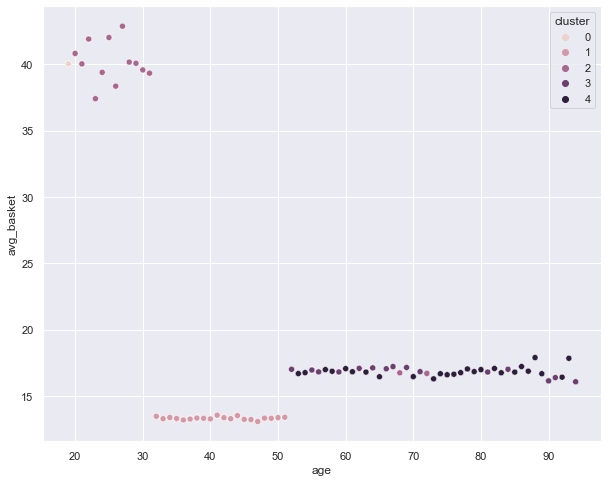

In [90]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x="age", y="avg_basket", data=X_km, hue="cluster")
plt.show()

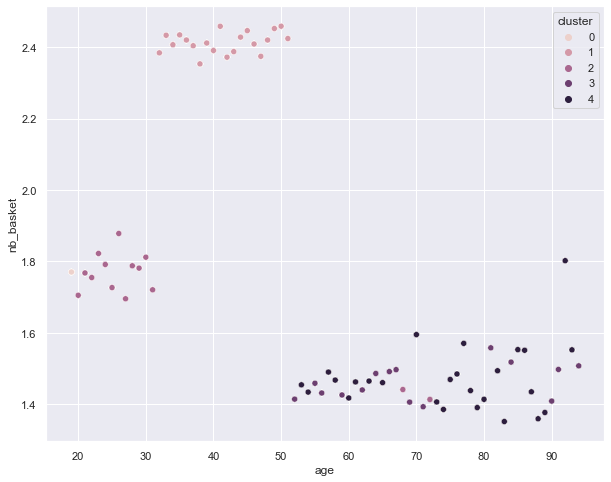

In [91]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x="age", y="nb_basket", data=X_km, hue="cluster")
plt.show()

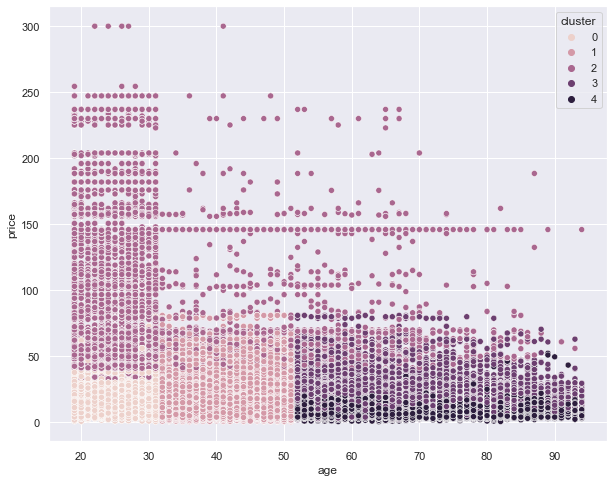

In [92]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x="age", y="price", data=X_km, hue="cluster")
plt.show()

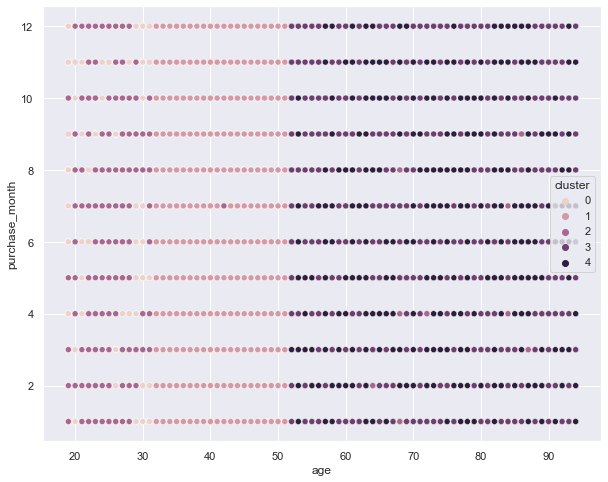

In [93]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x="age", y="purchase_month", data=X_km, hue="cluster")
plt.show()

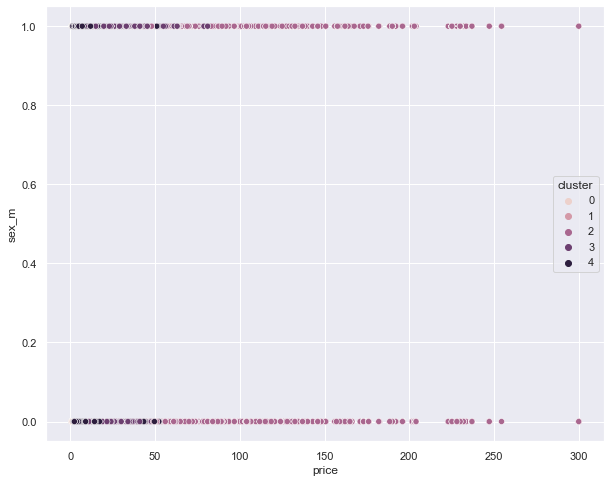

In [94]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x="price", y="sex_m", data=X_km, hue="cluster")
plt.show()